###### <span style="color: gray ">ライブラリをまとめてインポート</span>

In [1]:
# 数値計算およびデータ分析用ライブラリ
import numpy as np  # 数値計算を効率的に行うためのライブラリ
import pandas as pd  # データ分析を容易にするためのライブラリ

# グラフ描画用ライブラリ
import matplotlib.pyplot as plt  # グラフ描画のためのライブラリ
from matplotlib.colors import ListedColormap  # カラーマップを作成するためのモジュール
import seaborn as sns  # グラフ描画用ライブラリ（Matplotlibをベースにした高水準インターフェース）

# 統計および信号処理関数用ライブラリ
from scipy import stats  # 統計関数を扱うモジュール
from scipy import signal  # 信号処理関数を扱うモジュール
from scipy.signal import savgol_filter  # Savitzky-Golayフィルターを適用するためのモジュール
from scipy.optimize import curve_fit  # カーブフィッティングを行うための関数
from scipy.special import wofz  # Faddeeva関数を計算するための関数

# 機械学習モデルおよび評価関数
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score  # データ分割、グリッドサーチ、クロスバリデーション
from sklearn.cross_decomposition import PLSRegression  # 部分最小二乗回帰モデル
from sklearn.svm import SVR, SVC  # サポートベクターマシン（回帰、分類）
from sklearn.pipeline import Pipeline  # パイプラインの作成
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report  # 評価指標
from sklearn.ensemble import IsolationForest, RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier  # アンサンブル学習（外れ値検出、回帰、分類）
from sklearn.preprocessing import FunctionTransformer  # 関数変換器
from sklearn.decomposition import PCA  # 主成分分析
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # 線形判別分析
from sklearn.linear_model import LinearRegression  # 線形回帰

# その他のライブラリ
from tqdm import tqdm  # プログレスバー表示
import pickle  # オブジェクトの直列化・非直列化
from xgboost import XGBRegressor  # XGBoost回帰モデル


###### <span style="color: gray ">コード10.1　CSVファイルの読み込み</span>

In [2]:
file_spe = 'dataChapter10-11/spectra.csv'
file_prop = 'dataChapter10-11/prop.csv'
spectra = pd.read_csv(file_spe, index_col=0, header=0)
spectra=spectra.T
prop = pd.read_csv(file_prop, index_col=0, header=0)

###### <span style="color: gray ">コード10.2　データフレームへのラベルの追加とデータの概要の確認</span>

In [3]:
prop['label'] = None
prop.loc[prop.index.str.startswith('Aga'), 'label'] = 0
prop.loc[prop.index.str.startswith('Kiri'), 'label'] = 1
prop['label'] = prop['label'].astype(int)
prop.describe()

,mc,label
count,106.000000,106.000000
mean,50.780579,0.500000
std,19.649163,0.502375
min,0.000000,0.000000
25%,37.557799,0.000000
50%,54.073725,0.500000
75%,67.231813,1.000000
max,81.967213,1.000000


# <span style="color:RoyalBlue; ">11.1 アウトライヤーの検出と除去</span>

###### <span style="color: gray ">コード11.1　アウトライヤーの検出</span>

In [5]:
def remove_outliers_and_plot(spec, prop_data, contamination):
    """
    Parameters:
    spec (pandas.DataFrame): スペクトルデータ
    prop_data (pandas.Series): 目的変数
    contamination (float or 'auto'): アウトライヤーの割合または'auto'を指定

    Returns:
    None
    """
    # ①主成分分析 (PCA) を適用して次元削減
    pca = PCA(n_components=4)  # 最初の4つの主成分を取得
    spectra_pca = pca.fit_transform(spec)

    # ②Isolation Forestモデルを作成して適用 (スペクトルデータ)
    model_spec = IsolationForest(contamination=contamination, random_state=0)
    predict_spec = model_spec.fit_predict(spectra_pca)

    # ③Isolation Forestモデルを作成して適用 (目的変数)
    model_prop = IsolationForest(contamination=contamination, random_state=0)
    predict_prop = model_prop.fit_predict(prop_data.values.reshape(-1, 1))

    # ④アウトライヤーと判断されたサンプルのインデックスを取得
    outlier_idx_spec = np.where(predict_spec == -1)[0]
    outlier_idx_prop = np.where(predict_prop == -1)[0]
    outlier_idx = np.union1d(outlier_idx_spec, outlier_idx_prop)
    print("スペクトルからのアウトライヤーは",outlier_idx_spec)
    print("目的変数からのアウトライヤーは",outlier_idx_prop)
    
    # アウトライヤーを除去したスペクトルデータと目的変数を返す
    spectra_isolated = spec.iloc[predict_spec == 1, :]
    prop_isolated = prop_data.iloc[predict_prop == 1]
    # プロット (散布図)
    plt.figure(figsize=(6,6))
    plt.subplot(3, 1, 1)
    plt.scatter(range(len(prop_data)), prop_data, color='black', label='Normal')
    plt.scatter(outlier_idx, prop_data.iloc[outlier_idx], color='red', label='Outlier')
    plt.xlabel('Sample Number')
    plt.ylabel('Property')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.scatter(spectra_pca[:, 0], spectra_pca[:, 1], color='black', label='Normal')
    plt.scatter(spectra_pca[outlier_idx, 0], spectra_pca[outlier_idx, 1], color='red', label='Outlier')
    plt.xlabel('PC1 Score')
    plt.ylabel('PC2 Score')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.scatter(spectra_pca[:, 2], spectra_pca[:, 3], color='black', label='Normal')
    plt.scatter(spectra_pca[outlier_idx, 2], spectra_pca[outlier_idx, 3], color='red', label='Outlier')
    plt.xlabel('PC3 Score')
    plt.ylabel('PC4 Score')
    plt.legend()

    # プロット (PCAローディング)
    plt.figure(figsize=(8, 4))
    loadings = pca.components_
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.plot(loadings[i, :])
        plt.title(f'PC{i + 1} Loadings')
        plt.xlabel('Wavelength Index')
        plt.ylabel('Loading Value')
            # プロット (PCAローディング)
    
    plt.figure(figsize=(8, 4))
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.scatter(spectra_pca[:, i],prop_data, color='black', label='Normal')
        plt.scatter(spectra_pca[outlier_idx, i], prop_data.iloc[outlier_idx], color='red', label='Outlier')
        plt.title(f'PC{i + 1} score vs prop')
        plt.xlabel('score')
        plt.ylabel('prop')

    plt.tight_layout()
    plt.show()
    return spectra_isolated,prop_isolated

###### <span style="color: gray ">コード11.2　関数remove_outliers_and_plotの実行</span>

スペクトルからのアウトライヤーは [  0   1  52  53  54 105]
目的変数からのアウトライヤーは [ 51  52  53  54 104 105]


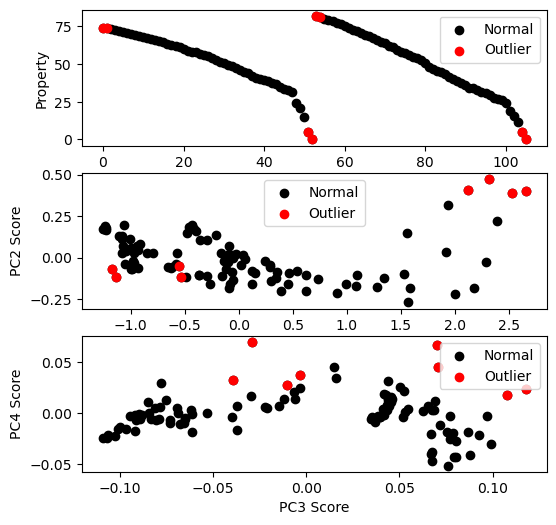

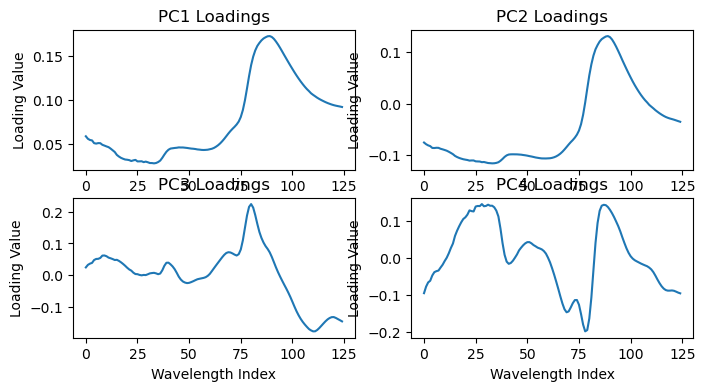

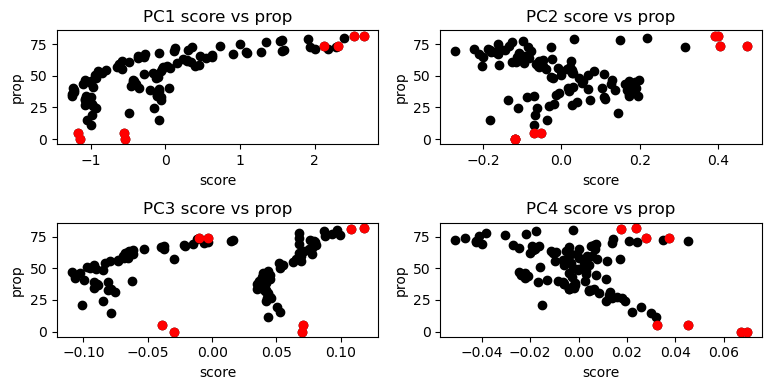

In [6]:
spectra_isolated,prop_isolated=remove_outliers_and_plot(spectra, prop["mc"], contamination=0.05)

# <span style="color:RoyalBlue; ">11.2 各モジュールでの標準化自由度</span>

###### <span style="color: gray ">コード11.3　スペクトルデータの標準化</span>

In [7]:
# pandasで標準化スペクトル計算
spectra_std_pd = (spectra - spectra.mean()) / spectra.std(ddof=0)
# numpyで標準化スペクトル計算
spectra_array=spectra.values
spectra_std_np = (spectra_array - np.mean(spectra_array, axis=0)) / np.std(spectra_array, axis=0, ddof=0)
# StandardScalerで標準化スペクトル計算
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
spectra_std_scaler = scaler.fit_transform(spectra_array)
# それぞれが同じか確認（最初の行の、最初の複数列）
print(spectra_std_pd.iloc[0,:5].values)
print(spectra_std_np[0,:5])
print(spectra_std_scaler[0,:5])

[1.45725553 1.40420156 1.37666445 1.3653331  1.28847642]
[1.45725553 1.40420156 1.37666445 1.3653331  1.28847642]
[1.45725553 1.40420156 1.37666445 1.3653331  1.28847642]


# <span style="color:RoyalBlue; ">11.3 PLSウェイトローディング，ローディング，回帰係数</span>

###### <span style="color: gray ">コード11.4　ウェイトローディングとローディングの表示</span>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


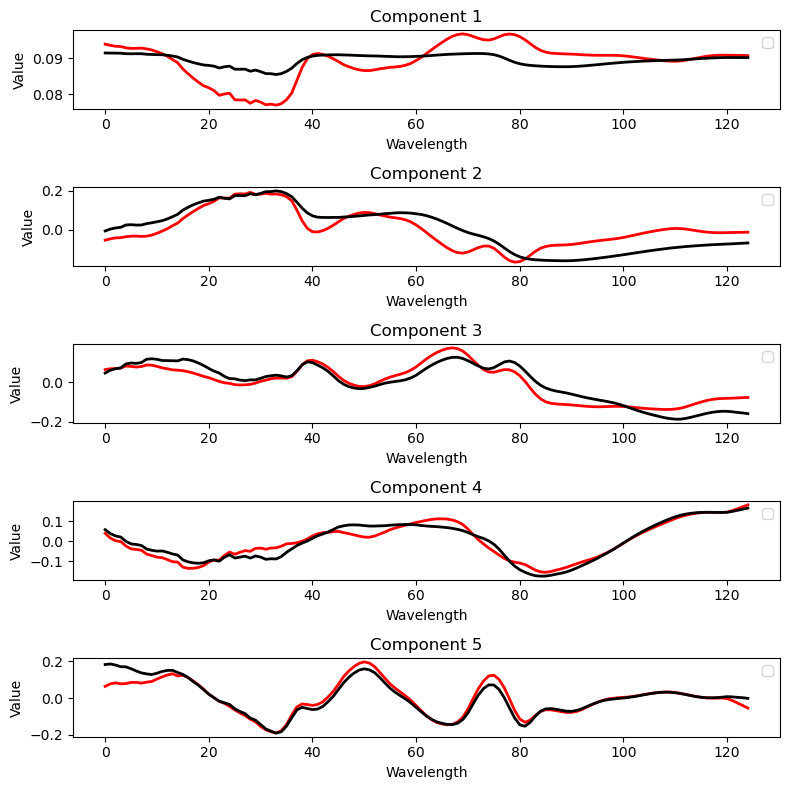

In [12]:
pls=PLSRegression(n_components=5)
pls.fit(spectra,prop["mc"])
weight=pls.x_weights_ # ウェイトローディング 直交規格化されている
loading=pls.x_loadings_ # ローディング　直交規格化されていない
fig, axes = plt.subplots(5, 1, figsize=(8,8))
for i in range(5):
    axes[i].plot(weight[:, i], 'r-', linewidth=2)  # 赤がウェイトローディング
    axes[i].plot(loading[:, i], 'k-', linewidth=2)       # 黒がローディング
    axes[i].set_title(f'Component {i + 1}')
    axes[i].set_xlabel('Wavelength')
    axes[i].set_ylabel('Value')
    axes[i].legend()
plt.tight_layout()
plt.show()

###### <span style="color: gray ">コード11.5　メソッドの予測値と内積からの予測値の比較</span>

In [18]:
# 標準化スペクトル算出(ddof=1)
spectra_std_pd = (spectra - spectra.mean()) / spectra.std(ddof=1)
mc_mean=np.mean(prop["mc"]) # 目的変数（含水率）の平均値
regression=pls.coef_# 回帰係数の抽出（目的変数の標準偏差が掛けられたもの）
pred_cal=np.dot(spectra_std_pd ,regression.T)#スペクトルと回帰係数の内積
pred_cal=pred_cal+mc_mean # 目的変数（含水率）の平均値を足す
pred=pls.predict(spectra) # メソッドを用いて予測
print(np.round(pred[:6].T,3))
print(np.round(pred_cal[:6].T,3))

[[82.312 74.267 76.628 70.795 68.234 74.5  ]]
[[82.312 74.267 76.628 70.795 68.234 74.5  ]]


# <span style="color:RoyalBlue; ">11.4 ウェイトローディングと寄与率</span>

###### <span style="color: gray ">コード11.6　PLS回帰モデルのクロスバリデーションと寄与率の分析</span>

In [20]:
def pls_cv_check(spec, prop_data, n_folds=5, max_components=10, scaleset=True):
    """
    Parameters:
    spec (pandas.DataFrame): スペクトルデータ（行が試料、列が波長）
    prop_data (pandas.Series): 目的変数
    n_folds (int): クロスバリデーションの分割数
    max_components (int): 試行する最大のPLS成分数
    scaleset (bool): スペクトルデータを標準化するかどうか

    Returns:
    dict: 結果をまとめた辞書
    """
    scores_cv = []
    scores_train = []
    explained_var_spec = []
    explained_var_prop = []
    coefficients = []
    pred = []

    # スペクトルデータの標準化(scalesetがFalseの場合は中心化)
    if scaleset:
        spec_normalized = (spec - spec.mean()) / spec.std(ddof=1)
    else:
        spec_normalized = spec - spec.mean()

    # ①PLSファクター数を増やしながら計算
    for n in range(1, max_components + 1):     
        pls = PLSRegression(n_components=n, scale=scaleset)
        # ②クロスバリデーションの決定係数の算出
        score_cv = cross_val_score(pls, spec, prop_data, cv=n_folds, scoring='r2').mean()
        pls.fit(spec, prop_data)
        # ③trainすべて使った場合の決定係数算出
        score_train = pls.score(spec, prop_data)
        scores_cv.append(score_cv)# ④appendで追加していく
        scores_train.append(score_train)
        # ⑤主成分スコア算出（引数はspec）
        transformed_spec = pls.transform(spec)
        # ⑥主成分スコアの分散合計/元のスペクトルの分散合計＝スペクトル寄与率
        explained_var_spec.append(np.var(transformed_spec, axis=0).sum() / np.var(spec_normalized, axis=0).sum())
        # ⑦予測値算出（引数はspec）
        predicted = pls.predict(spec)
        # ⑧予測値の分散合計/目的変数の分散合計＝目的変数寄与率
        explained_var_prop.append(np.var(predicted, axis=0).sum() / np.sum(np.var(prop_data, axis=0)))
        # ⑨各主成分における回帰係数を保存
        coefficients.append(pls.coef_)
        # ⑩各主成分における予測値を保存
        pred.append(predicted)

    optimal_n = np.argmax(scores_cv) + 1
    loadings = pls.x_loadings_
    weights = pls.x_weights_
    print("最適な主成分数数は",optimal_n)
    # ⑪各重要なパラメーターを辞書として出力
    results = {
        'optimal_n_components': optimal_n,
        'pred_value': pred,
        'r2_scores_train': scores_train,
        'r2_scores_cv': scores_cv,
        'explained_variances_spec': explained_var_spec,
        'explained_variances_prop': explained_var_prop,
        'loadings': loadings,
        'weights': weights,
        'regression_coefficients': coefficients
    }

    # 図の作成
    plt.figure(figsize=(8, 8))

    # スペクトルのプロット
    plt.subplot(3, 2, 1)
    plt.plot(spec.columns, spec_normalized.T, color='k', linewidth=0.5)
    plt.xlabel('Wavelength')
    plt.ylabel('Normalized Absorbance')
    plt.title('Normalized Spectra')

    # 主成分数とR2スコアの関係
    plt.subplot(3, 2, 3)
    plt.plot(range(1, max_components + 1), scores_train, 'k-o', label='Train')
    plt.plot(range(1, max_components + 1), scores_cv, 'r-o', label='CV')
    plt.xlabel('Number of PLS Components')
    plt.ylabel('R2 Score')
    plt.title('PLS Components vs R2 Score')
    plt.legend()
    
    # 主成分数と寄与率の関係
    plt.subplot(3, 2, 5)
    plt.plot(range(1, max_components + 1), explained_var_spec, 'm-o', label='Spectra')
    plt.plot(range(1, max_components + 1), explained_var_prop, 'c-o', label='Property')
    plt.xlabel('Number of PLS Components')
    plt.ylabel('Explained Variance')
    plt.title('PLS Components vs Explained Variance')
    plt.legend()

    # ウェイトローディングのプロット（コンポーネント1-3）
    plt.subplot(3, 2, 2)
    for i in range(3):
        plt.plot(spec.columns, weights[:, i], label=f'Component {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Weightloading')
    plt.title('Weightloadings (Components 1-3)')
    plt.legend()

    # ウェイトローディングのプロット（コンポーネント4-6）
    plt.subplot(3, 2, 4)
    for i in range(3, 6):
        plt.plot(spec.columns, weights[:, i], label=f'Component {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Weightloading')
    plt.title('Weightloadings (Components 4-6)')
    plt.legend()

    # ウェイトローディングのプロット（コンポーネント7-10）
    plt.subplot(3, 2, 6)
    for i in range(6, 10):
        plt.plot(spec.columns, weights[:, i], label=f'Component {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Weightloading')
    plt.title('Weightloadings (Components 7-10)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return results

###### <span style="color: gray ">コード11.7　関数pls_cv_checkの実行</span>

最適な主成分数数は 8


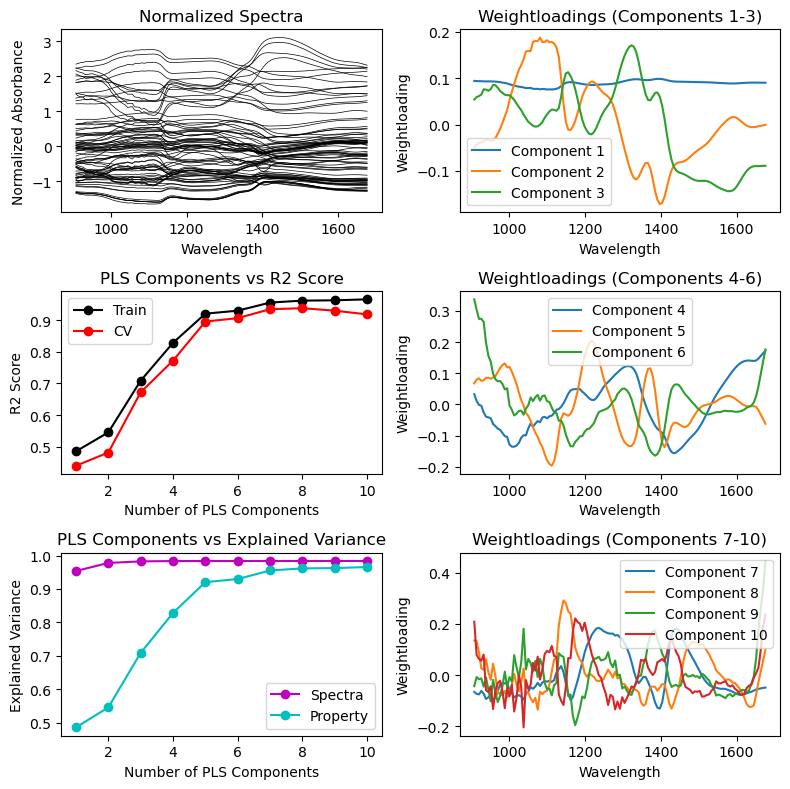

In [21]:
X_train, X_test, y_train, y_test = train_test_split(spectra, prop["mc"], test_size=0.2, random_state=2)
result=pls_cv_check(X_train, y_train, n_folds=5, max_components=10, scaleset=True)

###### <span style="color: gray ">コード11.8　各変数の抽出</span>

In [22]:
result["r2_scores_train"]

[0.48554068099403613,
 0.5453668476521718,
 0.7085479784964508,
 0.8281984369666202,
 0.9202489088846594,
 0.9296419009231413,
 0.9552302947577116,
 0.9614278471037658,
 0.9623933685454905,
 0.9655140671119311]

###### <span style="color: gray ">コード11.9　実測値と予測値の比較</span>

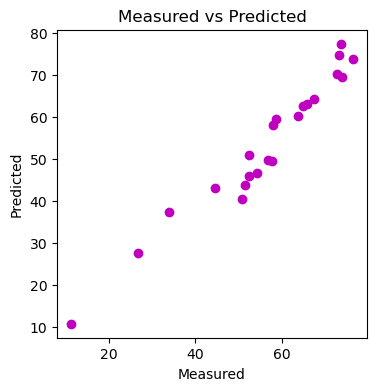

R²: 0.913


In [23]:
# 最適な主成分数を用いてインスタンスを作成
pls = PLSRegression(n_components=result["optimal_n_components"], scale=True)
pls.fit(X_train,y_train)
y_pred = pls.predict(X_test)
# 横軸は実測値y_test、縦軸は予測値の散布図を作成
plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred,c='m',label='opt')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Measured vs Predicted')
plt.show()
# 決定係数（R²）を計算
r2 = r2_score(y_test, y_pred)
print('R²:', np.round(r2,3))

###### <span style="color: gray ">コード11.10　pickleによるモデルの保存</span>

In [24]:
# モデルをpickle形式で保存
with open('pls_model.pkl', 'wb') as file:
    pickle.dump(pls, file)

###### <span style="color: gray ">コード11.11　保存されたモデルの読み込み</span>

In [25]:
# モデルを読み込む
with open('pls_model.pkl', 'rb') as file:
    loaded_pls = pickle.load(file)
loaded_y_pred = loaded_pls.predict(X_test)

# <span style="color:RoyalBlue; ">11.5 GridSearchCVによるクロスバリデーション</span>

###### <span style="color: gray ">コード11.12　グリッドサーチの実行</span>

Best PLS components: 8
Best SVR parameters: {'C': 100, 'gamma': 1}
PLS R²: 0.9133610015099756, RMSE: 4.678549694560221
SVR R²: 0.8191319809330573, RMSE: 6.7598245827176315


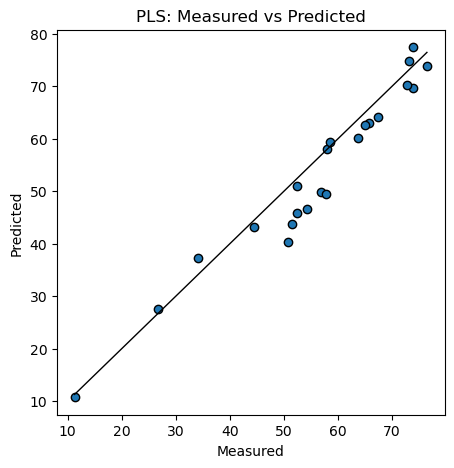

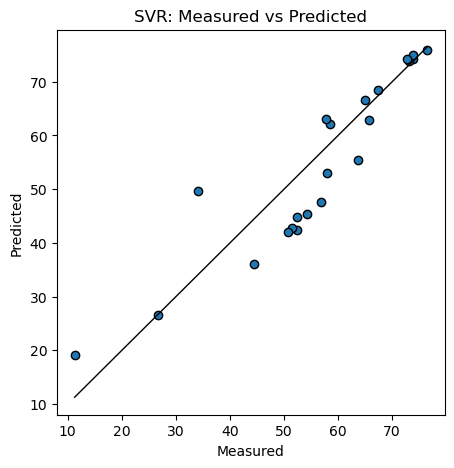

In [26]:
# ①PLSのグリッドサーチ
pls_params = {'n_components': list(range(1, 16))} # ①-1 ハイパーパラメーターを設定
pls_grid = GridSearchCV(PLSRegression(), param_grid=pls_params, cv=5, scoring='r2') # ①-2 インスタンス作成
pls_grid.fit(X_train, y_train)#①-3 fitメソッド
print(f"Best PLS components: {pls_grid.best_params_['n_components']}")

# ②SVRのグリッドサーチ
svr_params = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1]
}
svr_grid = GridSearchCV(SVR(kernel='rbf'), param_grid=svr_params, cv=5, scoring='r2')
svr_grid.fit(X_train, y_train)
print(f"Best SVR parameters: {svr_grid.best_params_}")

# ③最適化されたモデルでテストセットの予測
pls_predicted = pls_grid.predict(X_test)
svr_predicted = svr_grid.predict(X_test)

# PLSの性能評価
pls_r2 = r2_score(y_test, pls_predicted)
pls_mse = mean_squared_error(y_test, pls_predicted)
print(f'PLS R²: {pls_r2}, RMSE: {np.sqrt(pls_mse)}')

# SVRの性能評価
svr_r2 = r2_score(y_test, svr_predicted)
svr_mse = mean_squared_error(y_test, svr_predicted)
print(f'SVR R²: {svr_r2}, RMSE: {np.sqrt(svr_mse)}')

# PLSの散布図
plt.figure(figsize=(5, 5))
plt.scatter(y_test, pls_predicted, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k-', lw=1)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('PLS: Measured vs Predicted')
plt.show()

# SVRの散布図
plt.figure(figsize=(5,5))
plt.scatter(y_test, svr_predicted, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k-', lw=1)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('SVR: Measured vs Predicted')
plt.show()

# <span style="color:RoyalBlue; ">11.6 パイプイラインを用いたモデルの最適化</span>

###### <span style="color: gray ">コード11.13　微分スペクトルを用いたPLS回帰モデルの最適化</span>

In [29]:
# ①Savitzky-Golayフィルターで微分スペクトルを計算
def differentiate_spectra(spectra, order, window_length):
    return savgol_filter(spectra, window_length=window_length, polyorder=2, deriv=order)

# ②微分スペクトルの作成
X_train_1st_derivative = [differentiate_spectra(X_train, order=1, window_length=i) for i in range(3, 14, 2)]
X_train_2nd_derivative = [differentiate_spectra(X_train, order=2, window_length=i) for i in range(3, 14, 2)]

# ③PLSモデルの最適な主成分数を決定し、クロスバリデーションで評価
def optimize_pls(X, y, max_components=15):
    pls_params = {'n_components': range(1, max_components + 1)}
    pls_grid = GridSearchCV(PLSRegression(scale=True), param_grid=pls_params, cv=5, scoring='r2')
    pls_grid.fit(X, y)
    return pls_grid.best_estimator_, pls_grid.best_score_

# ④元のスペクトルと微分スペクトルでPLSモデルを最適化
models = [optimize_pls(X_train, y_train)] + [optimize_pls(X, y_train) for X in X_train_1st_derivative] + [optimize_pls(X, y_train) for X in X_train_2nd_derivative]

# 結果の表示
results = pd.DataFrame({
    'Model': ['Original'] + [f'1st Derivative (window={i})' for i in range(3, 14, 2)] + [f'2nd Derivative (window={i})' for i in range(3, 14, 2)],
    'Optimal Components': [model[0].n_components for model in models],
    'R² (CV)': [round(model[1], 3) for model in models]
})
print(results)

                         Model  Optimal Components  R² (CV)
0                     Original                   8    0.937
1    1st Derivative (window=3)                  10    0.944
2    1st Derivative (window=5)                   9    0.944
3    1st Derivative (window=7)                  11    0.941
4    1st Derivative (window=9)                  12    0.935
5   1st Derivative (window=11)                   8    0.936
6   1st Derivative (window=13)                   8    0.937
7    2nd Derivative (window=3)                   7    0.907
8    2nd Derivative (window=5)                   8    0.932
9    2nd Derivative (window=7)                   8    0.939
10   2nd Derivative (window=9)                   8    0.938
11  2nd Derivative (window=11)                   8    0.941
12  2nd Derivative (window=13)                   8    0.940


###### <span style="color: gray ">コード11.14　スムージングポイントの数による微分スペクトルの変化</span>

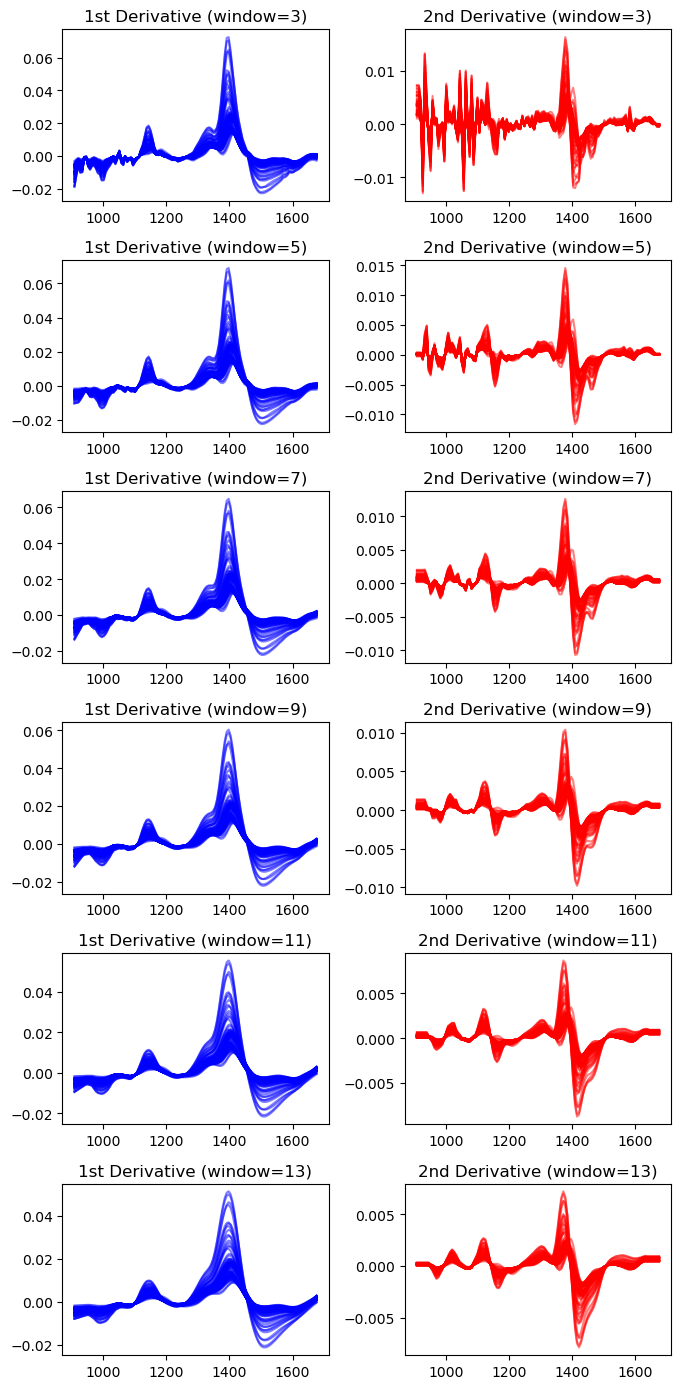

In [30]:
fig, axes = plt.subplots(6, 2, figsize=(7,14))
for i, (X_1st, X_2nd) in enumerate(zip(X_train_1st_derivative, X_train_2nd_derivative)):
    axes[i, 0].plot(X_train.columns,X_1st.T, color='blue', alpha=0.5)
    axes[i, 0].set_title(f'1st Derivative (window={3 + 2*i})')
    axes[i, 1].plot(X_train.columns,X_2nd.T, color='red', alpha=0.5)
    axes[i, 1].set_title(f'2nd Derivative (window={3 + 2*i})')
plt.tight_layout()
plt.show()

###### <span style="color: gray ">コード11.15　パイプラインの定義</span>

In [31]:
# パイプラインの定義
pipeline = Pipeline([
    ('smoothing', FunctionTransformer(savgol_filter, kw_args={'window_length': 5, 'polyorder': 2})),
    ('pca', PCA()),
    ('regression', LinearRegression())
])

###### <span style="color: gray ">コード11.16　ハイパーパラメータチューニングのためのパラメータグリッドの定義</span>

In [32]:
# パラメータグリッドの定義
param_grid = {
    'smoothing__kw_args': [{'window_length': w, 'polyorder': 2} for w in [5, 7, 9]],
    'pca__n_components': range(1, 16),
}

# GridSearchCVのインスタンス作成
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')

# グリッドサーチの実行
grid_search.fit(X_train, y_train)

# 最適なパラメータの表示
print("Best parameters:")
print(grid_search.best_params_)

# 最適なモデルのスコアの表示
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters:
{'pca__n_components': 10, 'smoothing__kw_args': {'window_length': 9, 'polyorder': 2}}
Best cross-validation score: 0.94


###### <span style="color: gray ">コード11.17　テストセットを用いた性能評価</span>

In [36]:
#最適化されたモデルでテストセットの予測
predicted = grid_search.predict(X_test)
# 性能評価
r2_predicted= r2_score(y_test, predicted)
mse_predicted = mean_squared_error(y_test,predicted)
print(f'PLS R²: {pls_r2:.2f}, RMSE: {np.sqrt(mse_predicted):.2f}')

PLS R²: 0.91, RMSE: 4.11


###### <span style="color: gray ">コード11.18　さまざまな回帰アルゴリズムを使用したパイプラインの定義とハイパーパラメータの最適化</span>

In [37]:
# パイプラインの定義
pipelines = {
    'PCR': Pipeline([
        ('pca', PCA()),
        ('regressor', LinearRegression())
    ]),
    'PLS': Pipeline([
        ('regressor', PLSRegression())
    ]),
    'SVR': Pipeline([
        ('regressor', SVR())
    ]),
    'RandomForest': Pipeline([
        ('regressor', RandomForestRegressor())
    ]),
    'GradientBoosting': Pipeline([
        ('regressor', GradientBoostingRegressor())
    ]),
    'XGB': Pipeline([
        ('regressor', XGBRegressor())
    ])
}

# ハイパーパラメータの設定
param_grids = {
    'PCR': {'pca__n_components': range(1, 11)},
    'PLS': {'regressor__n_components': range(1, 11)},
    'SVR': {'regressor__C': [0.1, 1, 10], 'regressor__gamma': ['scale', 'auto']},
    'RandomForest': {'regressor__n_estimators': [10, 50, 100], 'regressor__max_depth': [None, 5, 10]},
    'GradientBoosting': {'regressor__n_estimators': [100, 200], 'regressor__learning_rate': [0.01, 0.1]},
    'XGB': {'regressor__n_estimators': [100, 200], 'regressor__learning_rate': [0.01, 0.1]}
}

# 各パイプラインに対してGridSearchCVを実行
results = {}
for name, pipeline in pipelines.items():
    grid = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='r2')
    grid.fit(X_train, y_train)
    results[name] = {
        'Best Parameters': grid.best_params_,
        'Best Score': grid.best_score_
    }

# 結果の表示
for name, result in results.items():
    print(f'{name}:')
    print(f'Best Parameters: {result["Best Parameters"]}')
    print(f'Best Score: {result["Best Score"]:.2f}\n')


PCR:
Best Parameters: {'pca__n_components': 10}
Best Score: 0.94

PLS:
Best Parameters: {'regressor__n_components': 8}
Best Score: 0.94

SVR:
Best Parameters: {'regressor__C': 10, 'regressor__gamma': 'scale'}
Best Score: 0.47

RandomForest:
Best Parameters: {'regressor__max_depth': None, 'regressor__n_estimators': 10}
Best Score: 0.57

GradientBoosting:
Best Parameters: {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 200}
Best Score: 0.68

XGB:
Best Parameters: {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 200}
Best Score: 0.58



###### <span style="color: gray ">コード11.19　PCAとSVMを用いたクロスバリデーションとハイパーパラメータの最適化</span>

In [38]:
X_train, X_test, y_train, y_test = train_test_split(spectra, prop, test_size=0.3, random_state=2)
# パイプラインの定義
pipeline = Pipeline([
    ('pca', PCA()),
    ('svm', SVC())
])
# ハイパーパラメータのグリッド
param_grid = {
    'pca__n_components': range(1, 11),
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [0.001, 0.01, 0.1, 1]
}
# GridSearchCVの設定
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# グリッドサーチの実行
grid_search.fit(X_train, y_train["label"])

# 最適なパラメータとスコアの表示
print("Best parameters:")
print(grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# テストデータでの性能評価
y_pred = grid_search.predict(X_test)
print(classification_report(y_test["label"], y_pred))

Best parameters:
{'pca__n_components': 3, 'svm__C': 100, 'svm__gamma': 0.1}
Best cross-validation score: 0.99
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        19
           1       0.87      1.00      0.93        13

    accuracy                           0.94        32
   macro avg       0.93      0.95      0.94        32
weighted avg       0.95      0.94      0.94        32



###### <span style="color: gray ">コード11.20　最適なパラメータでPCAとSV分類を設定</span>

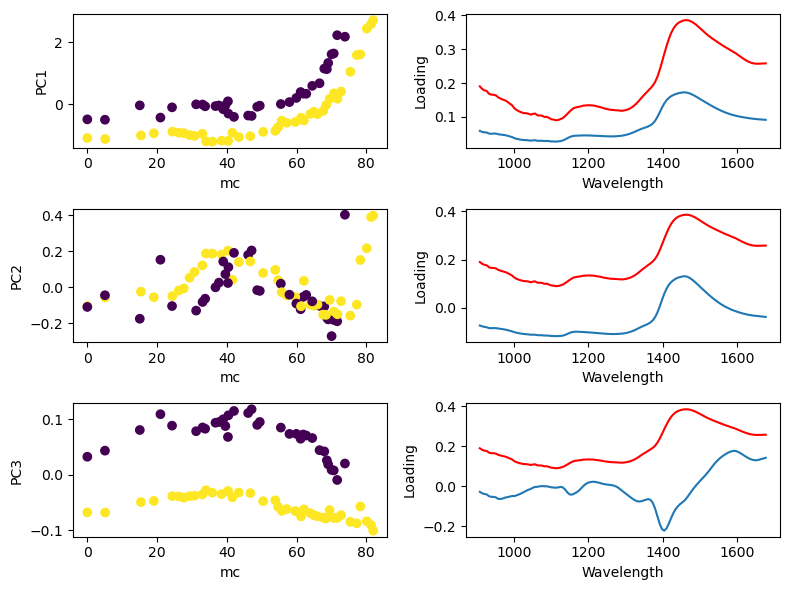

In [39]:
# 最適なパラメータでPCAとSVMを設定
pca = PCA(n_components=3)
svm = SVC(C=100, gamma=0.1, probability=True)

# PCAで変換
X_train_pca = pca.fit_transform(X_train)

# 新たな図でスコアとローディングのプロット
fig, axes = plt.subplots(3, 2, figsize=(8, 6))
mean_spectrum = X_train.mean(axis=0)
# スコアプロット
for i in range(3):
    axes[i, 0].scatter(y_train["mc"], X_train_pca[:, i], c=y_train["label"])
    axes[i, 0].set_xlabel('mc')
    axes[i, 0].set_ylabel(f'PC{i+1}')

# ローディングプロット
for i in range(3):
    axes[i, 1].plot(X_train.columns,pca.components_[i], label=f'PC{i+1}')
    axes[i, 1].plot(X_train.columns,mean_spectrum.values, color='r', label='Mean Spectrum')
    axes[i, 1].set_xlabel('Wavelength')
    axes[i, 1].set_ylabel('Loading')
plt.tight_layout()
plt.show()

###### <span style="color: gray ">コード11.21　PCAを用いたSV分類</span>

In [40]:
# PCAで変換
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# PC1とPC2を使用
svm.fit(X_train_pca[:, [0, 1]], y_train["label"])
y_pred_12 = svm.predict(X_test_pca[:, [0, 1]])
print("Using PC1 and PC2:")
print(classification_report(y_test["label"], y_pred_12))

# PC2とPC3を使用
svm.fit(X_train_pca[:, [1, 2]], y_train["label"])
y_pred_23 = svm.predict(X_test_pca[:, [1, 2]])
print("Using PC1 and PC2:")
print(classification_report(y_test["label"], y_pred_23))
# PC1とPC3を使用
svm.fit(X_train_pca[:, [0, 2]], y_train["label"])
y_pred_13 = svm.predict(X_test_pca[:, [0, 2]])
print("Using PC1 and PC2:")
print(classification_report(y_test["label"], y_pred_13))

Using PC1 and PC2:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        19
           1       0.91      0.77      0.83        13

    accuracy                           0.88        32
   macro avg       0.88      0.86      0.87        32
weighted avg       0.88      0.88      0.87        32

Using PC1 and PC2:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91        19
           1       0.81      1.00      0.90        13

    accuracy                           0.91        32
   macro avg       0.91      0.92      0.91        32
weighted avg       0.92      0.91      0.91        32

Using PC1 and PC2:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg     